In [1]:
import pandas as pd
import numpy as np
import time
from itertools import combinations

from fast_ml import eda
from fast_ml.utilities import display_all
from fast_ml.model_development import train_valid_test_split, all_classifiers, execute_model
from fast_ml.model_evaluation import get_fi, threshold_evaluation

import fuzzywuzzy
from fuzzywuzzy import fuzz
import lightgbm
from lightgbm import LGBMClassifier

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from joblib import dump
SEED = 2021

In [2]:
print('Numpy version: ' , np.__version__)
print('Pandas version: ' , pd.__version__)
print('LightGBM version: ' , lightgbm.__version__)
print('fuzzywuzzy version: ' , fuzzywuzzy.__version__)
print('Sklearn version: ' , sklearn.__version__)

Numpy version:  1.19.2
Pandas version:  1.1.3
LightGBM version:  3.1.1
fuzzywuzzy version:  0.18.0
Sklearn version:  0.23.2


In [3]:
df = pd.read_csv('data_interview_test.csv', sep=':')

def receipt_match(row):
    #print(row)
    match_score = fuzz.ratio(str(row['matched_transaction_id']), str(row['feature_transaction_id']))
    return match_score

df['score'] = df.apply(receipt_match, axis=1)
df['target'] = np.where(df['score']==100, 1,0)

df_orig = df.copy()
df.shape

(12034, 16)

In [4]:
df.head()

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,score,target
0,10000,10000,10468,10000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,57,0
1,10000,10000,10468,10001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,57,0
2,10000,10000,10468,10003,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,57,0
3,10000,10000,10468,10004,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,71,0
4,10000,10000,10468,10005,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,57,0


In [5]:
df_summary = eda.df_info(df)
display_all(df_summary)

,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
receipt_id,int64,Numerical,1155,"[10000, 10001, 10002, 10003, 10004, 10005, 100...",0,0
company_id,int64,Numerical,5,"[10000, 20000, 30000, 40000, 50000]",0,0
matched_transaction_id,int64,Numerical,1155,"[10468, 10605, 10286, 10412, 10413, 10474, 102...",0,0
feature_transaction_id,int64,Numerical,2132,"[10000, 10001, 10003, 10004, 10005, 10006, 100...",0,0
DateMappingMatch,float64,Numerical,11,"[0.0, 0.9, 0.95, 0.55, 0.85, 0.65, 1.0, 0.75, ...",0,0
AmountMappingMatch,float64,Numerical,5,"[0.0, 0.4, 0.7, 0.6, 0.9]",0,0
DescriptionMatch,float64,Numerical,5,"[0.0, 0.6, 0.4, 0.8, 0.2]",0,0
DifferentPredictedTime,float64,Numerical,2,"[1.0, 0.0]",0,0
TimeMappingMatch,float64,Numerical,2,"[0.0, 1.0]",0,0
PredictedNameMatch,float64,Numerical,5,"[0.0, 0.8, 0.6, 0.4, 0.2]",0,0


In [6]:
df.query("receipt_id==10001")

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,score,target
20,10001,10000,10605,10596,0.0,0.4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,71,0
21,10001,10000,10605,10597,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,71,0
22,10001,10000,10605,10598,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,71,0
23,10001,10000,10605,10599,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,71,0
24,10001,10000,10605,10600,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,86,0
25,10001,10000,10605,10605,0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,100,1
26,10001,10000,10605,10606,0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,86,0


# EDA

### Target Variable

In [7]:
df['target'].value_counts()

0    11177
1      857
Name: target, dtype: int64

In [8]:
100*df['target'].value_counts(normalize=True)

0    92.878511
1     7.121489
Name: target, dtype: float64

### Company level Receipts that are matched vs not matched

In [9]:
df['company_id'].value_counts()

30000    4926
20000    2375
10000    2351
50000    1383
40000     999
Name: company_id, dtype: int64

In [10]:
cmp_rec_grp = df.groupby(by=['company_id', 'receipt_id'])['target'].max()
cmp_rec_grp = cmp_rec_grp.reset_index()
pd.pivot_table(cmp_rec_grp, index = 'company_id' ,columns = 'target',aggfunc='count', margins=True, margins_name='Total')

receipt_id           
target              0    1 Total
company_id                      
10000              52  154   206
20000              68  145   213
30000             120  250   370
40000              25  123   148
50000              33  185   218
Total             298  857  1155

### Categorical Plots

In [11]:
cat_vars = ['company_id', 'DateMappingMatch', 'AmountMappingMatch', 'DescriptionMatch', 'DifferentPredictedTime', 
            'TimeMappingMatch', 'PredictedNameMatch', 'ShortNameMatch', 'DifferentPredictedDate',
            'PredictedAmountMatch', 'PredictedTimeCloseMatch', 'score']

**<u> 1. Plot for company_id</u>**

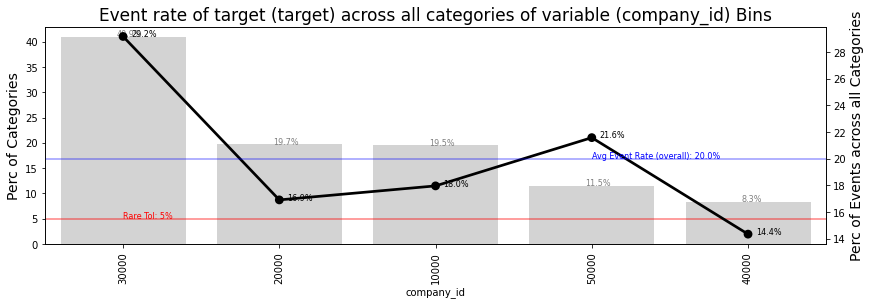

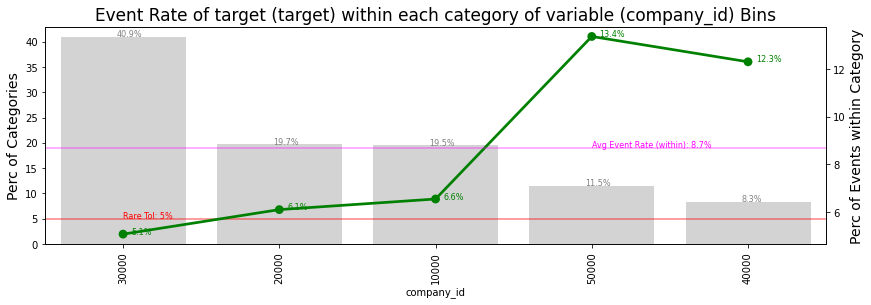

**<u> 2. Plot for DateMappingMatch</u>**

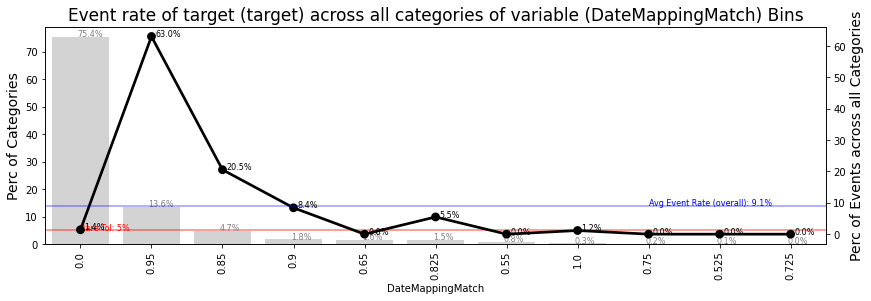

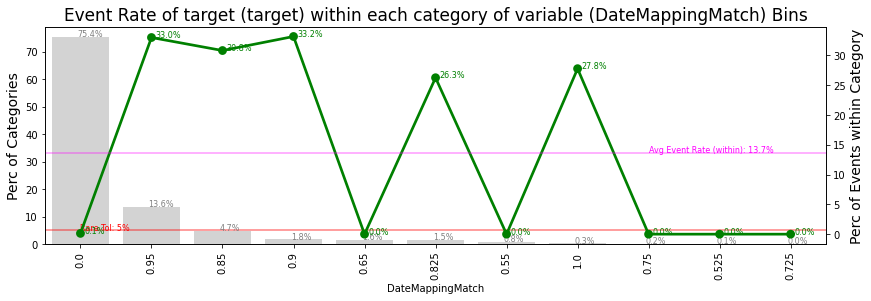

**<u> 3. Plot for AmountMappingMatch</u>**

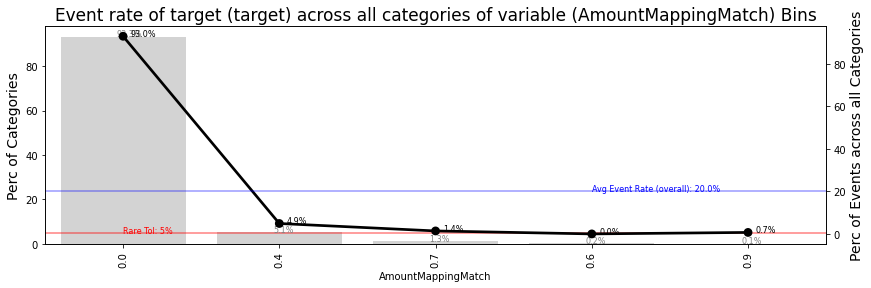

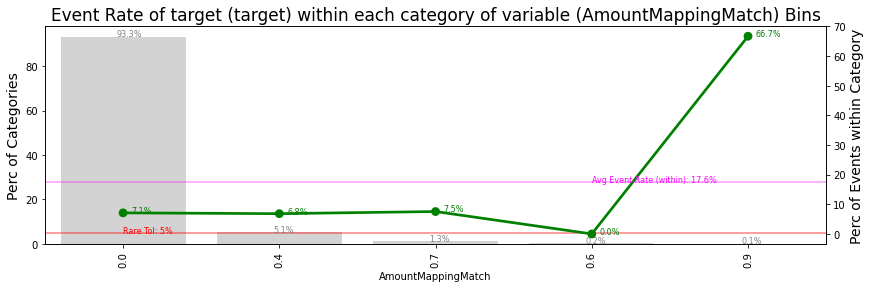

**<u> 4. Plot for DescriptionMatch</u>**

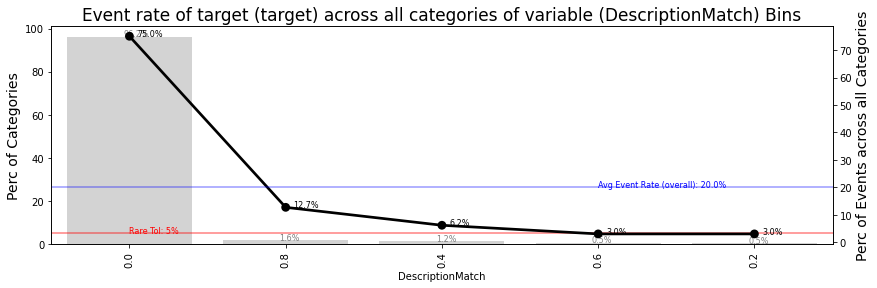

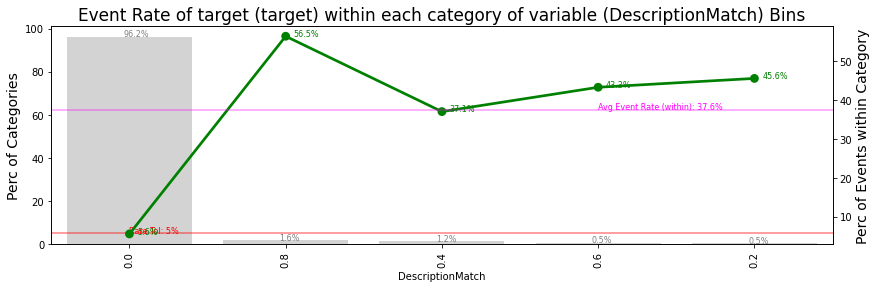

**<u> 5. Plot for DifferentPredictedTime</u>**

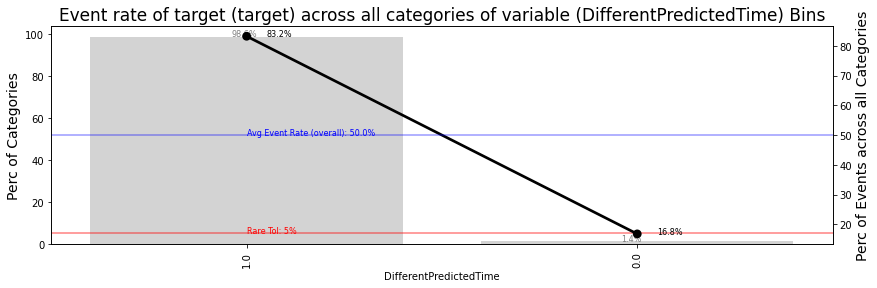

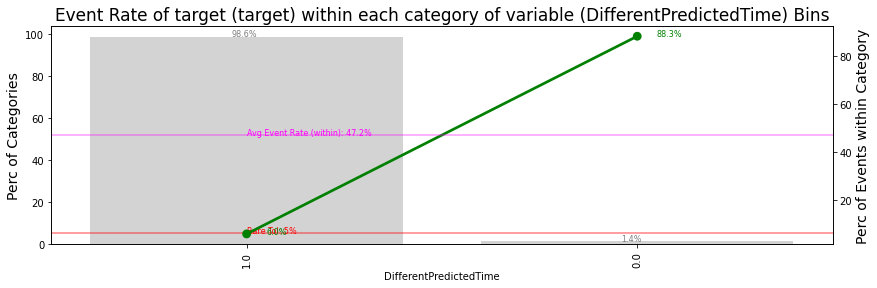

**<u> 6. Plot for TimeMappingMatch</u>**

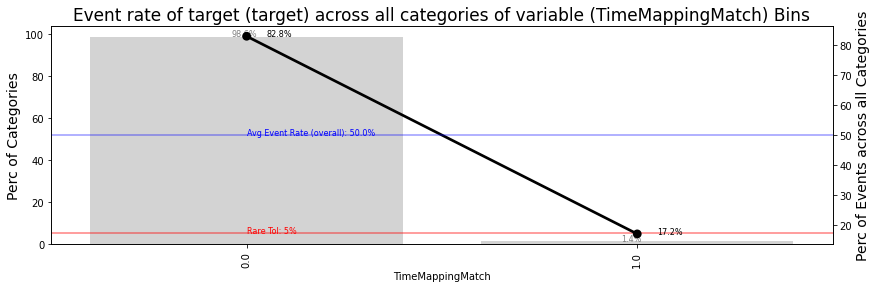

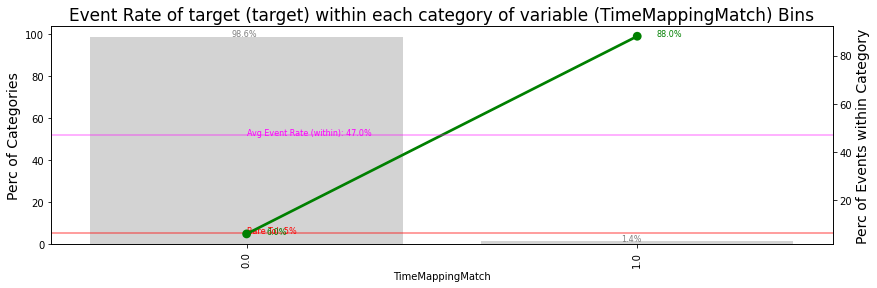

**<u> 7. Plot for PredictedNameMatch</u>**

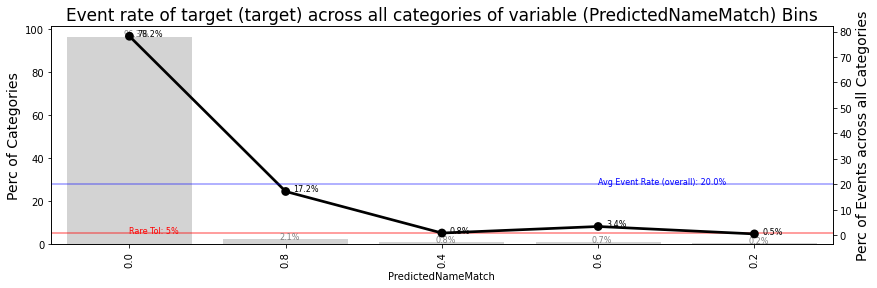

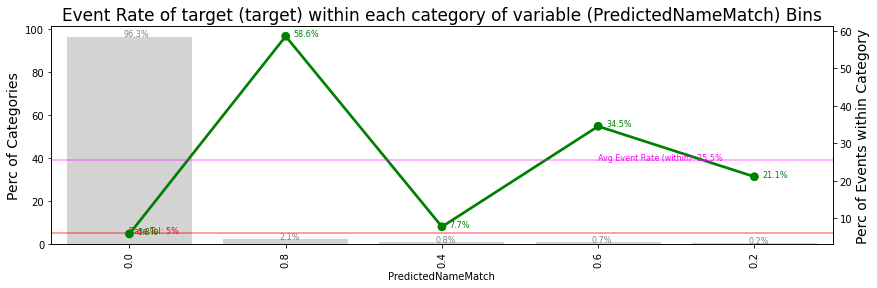

**<u> 8. Plot for ShortNameMatch</u>**

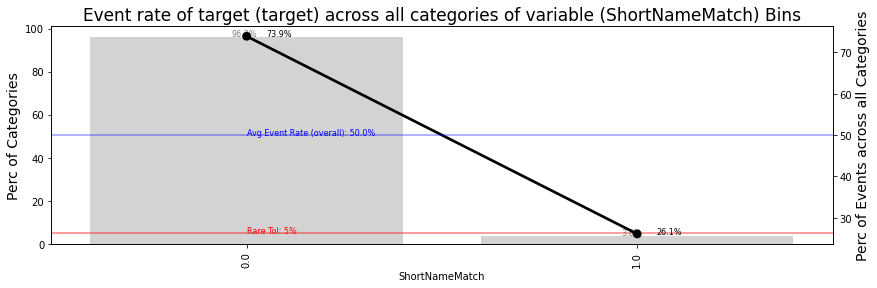

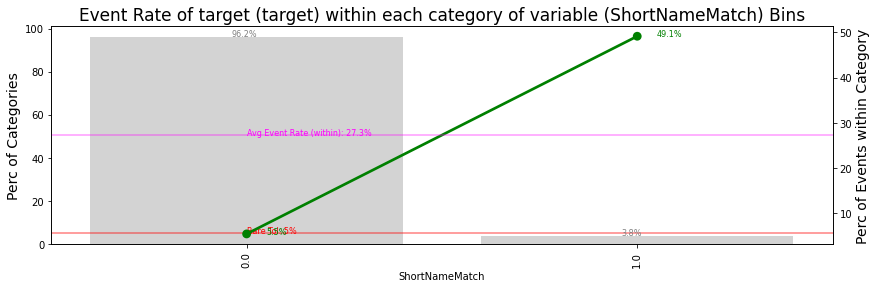

**<u> 9. Plot for DifferentPredictedDate</u>**

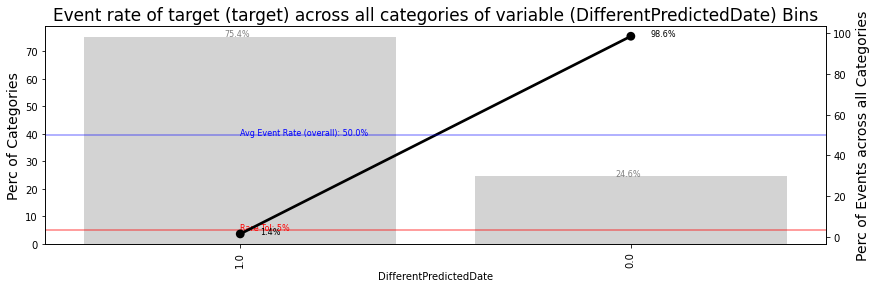

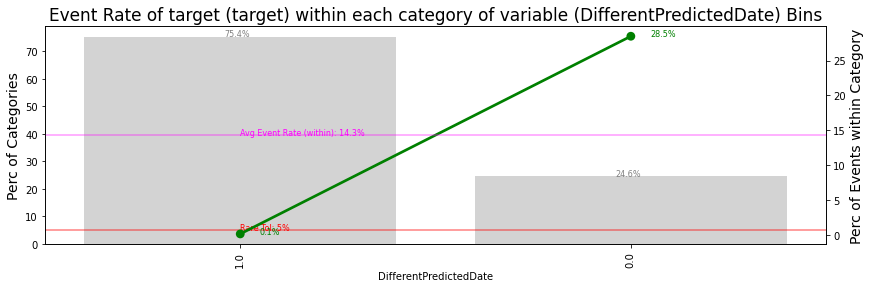

**<u> 10. Plot for PredictedAmountMatch</u>**

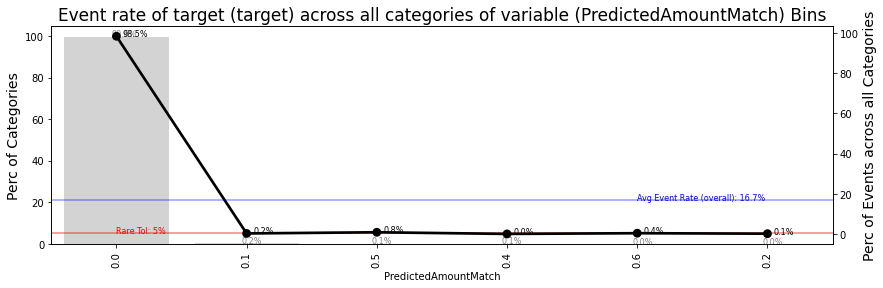

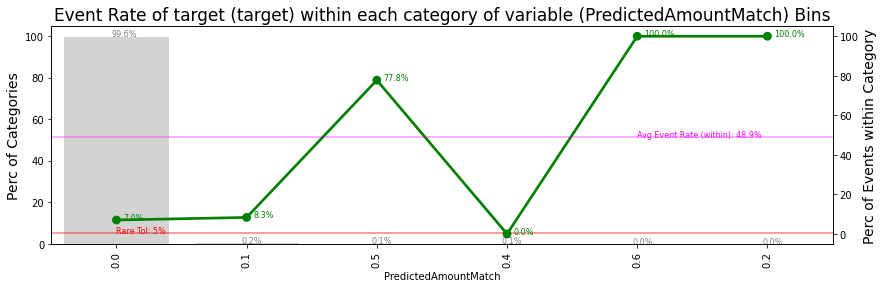

**<u> 11. Plot for PredictedTimeCloseMatch</u>**

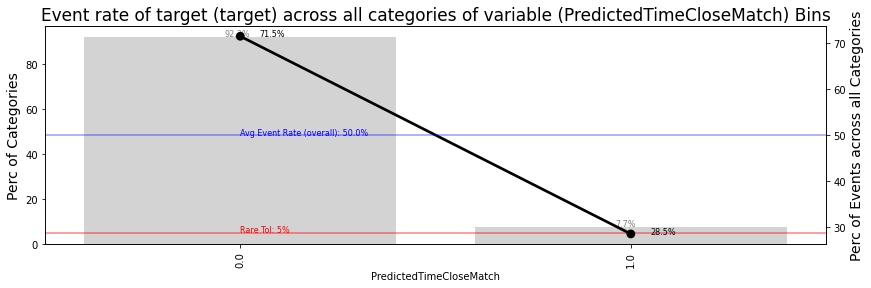

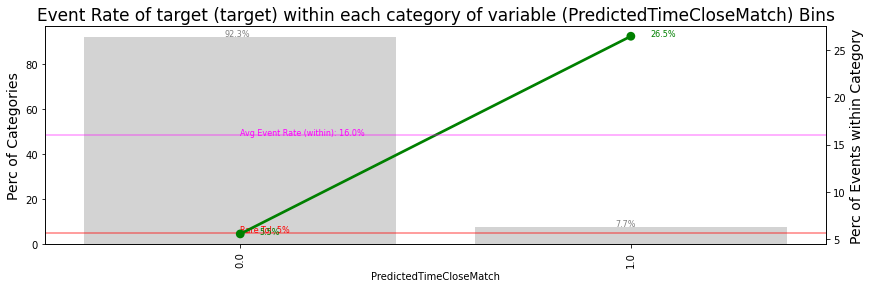

**<u> 12. Plot for score</u>**

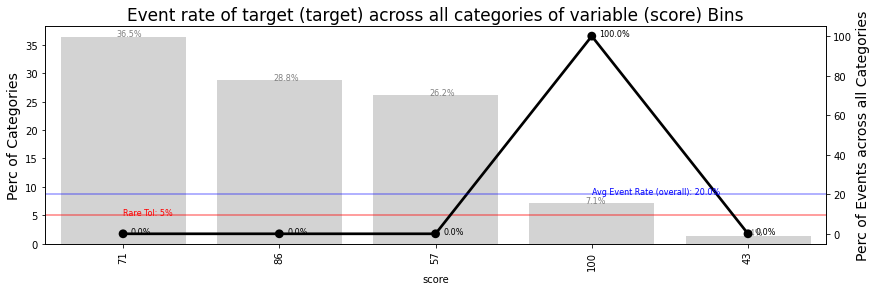

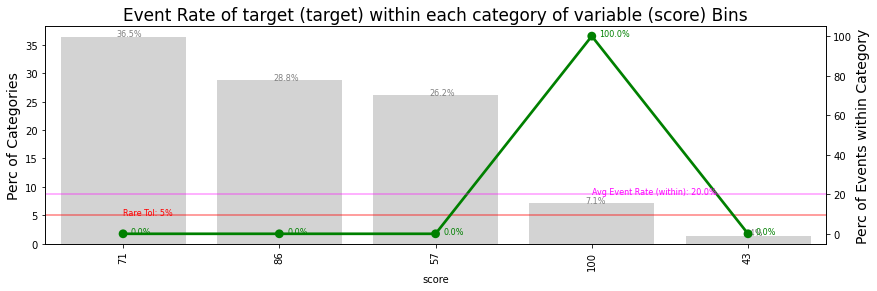

In [12]:
eda.categorical_plots_with_target(df, variables=cat_vars, target='target', model_type='clf', rare_tol2=None)

# All Classifiers for baseline

In [13]:
FEATURES = ['DateMappingMatch', 'AmountMappingMatch', 'DescriptionMatch', 'DifferentPredictedTime', 
            'TimeMappingMatch', 'PredictedNameMatch', 'ShortNameMatch', 'DifferentPredictedDate',
            'PredictedAmountMatch', 'PredictedTimeCloseMatch']

TARGET = 'target'
FEATURES.extend([TARGET])

model_df = df[FEATURES]
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(model_df, TARGET, random_state=SEED)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape) 


(9627, 10)
(9627,)
(1203, 10)
(1203,)
(1204, 10)
(1204,)


(None, None)

In [14]:
model_results_df = all_classifiers(X_train, y_train, X_valid, y_valid, X_test, y_test, 
                                   threshold_by = 'ROC AUC' ,verbose = False)

display_all(model_results_df)

,Algorithm,Run Time,Dataset,No obs,Threshold,TP,FP,TN,FN,Accuracy Score,Precision Score,Recall Score,F1 Score,ROC AUC Score
0,AdaBoostClassifier,0.64,train,9627,0.50,385,99,8839,304,0.958139,0.795455,0.558781,0.656436,0.773852
1,AdaBoostClassifier,0.64,valid,1203,0.50,44,14,1104,41,0.954281,0.758621,0.517647,0.615385,0.752562
2,AdaBoostClassifier,0.64,test,1204,0.50,46,12,1109,37,0.959302,0.793103,0.554217,0.652482,0.771756
3,BaggingClassifier,0.33,train,9627,0.05,685,1374,7564,4,0.856861,0.332686,0.994194,0.498544,0.920234
4,BaggingClassifier,0.33,valid,1203,0.05,84,170,948,1,0.857855,0.330709,0.988235,0.495575,0.918089
5,BaggingClassifier,0.33,test,1204,0.05,81,177,944,2,0.851329,0.313953,0.975904,0.475073,0.909004
6,ExtraTreesClassifier,0.86,train,9627,0.05,685,1363,7575,4,0.858004,0.334473,0.994194,0.500548,0.920850
7,ExtraTreesClassifier,0.86,valid,1203,0.05,84,173,945,1,0.855362,0.326848,0.988235,0.491228,0.916747
8,ExtraTreesClassifier,0.86,test,1204,0.05,80,178,943,3,0.849668,0.310078,0.963855,0.469208,0.902534
9,GradientBoostingClassifier,1.12,train,9627,0.10,680,1357,7581,9,0.858107,0.333824,0.986938,0.498899,0.917557


# Feature Engineering

In [15]:


DROP_FEATURES = ['receipt_id', 'company_id', 'matched_transaction_id','feature_transaction_id', 'score']
TARGET = 'target'


df['Mapping_Desc_Pred_DiffPred_Sum'] = df['DateMappingMatch'] + df['AmountMappingMatch']  +df['TimeMappingMatch'] \
                + df['DescriptionMatch'] + +df['ShortNameMatch'] \
                + df['PredictedNameMatch']+ df['PredictedAmountMatch']+ df['PredictedTimeCloseMatch'] \
                + df['DifferentPredictedTime'] + df['DifferentPredictedDate']

df['Mapping_Desc_Sum'] = df['DateMappingMatch'] + df['AmountMappingMatch']  +df['TimeMappingMatch'] \
                + df['DescriptionMatch'] + +df['ShortNameMatch']

df['Mapping_Desc_Pred_Sum'] = df['DateMappingMatch'] + df['AmountMappingMatch']  +df['TimeMappingMatch'] \
                + df['DescriptionMatch'] + +df['ShortNameMatch'] \
                + df['PredictedNameMatch']+ df['PredictedAmountMatch']+ df['PredictedTimeCloseMatch']

df['NegDifferentPredictedTime'] = -1 * df['DifferentPredictedTime']   
df['NegDifferentPredictedDate'] = -1 * df['DifferentPredictedDate'] 


comb_vars = ['DateMappingMatch', 'AmountMappingMatch', 'DescriptionMatch', 'NegDifferentPredictedTime', 
            'TimeMappingMatch', 'PredictedNameMatch', 'ShortNameMatch', 'NegDifferentPredictedDate',
            'PredictedAmountMatch', 'PredictedTimeCloseMatch', ]

# Interaction features of 2 variables
comb2 = combinations(comb_vars,2)

comb2_vars = []
for i in list(comb2):
    var = i[0] + '_' + i[1]
    comb2_vars.append(var)
    
    df[var] = df[i[0]] + df[i[1]]

print(comb2_vars[0:5])

# Interaction features of 3 variables
comb3 = combinations(comb_vars,3)

comb3_vars = []
for i in list(comb3):
    var = i[0] + '_' + i[1] + '_' + i[2]
    comb3_vars.append(var)
    
    df[var] = df[i[0]] + df[i[1]] + df[i[2]]
print()
print(comb3_vars[0:5])

['DateMappingMatch_AmountMappingMatch', 'DateMappingMatch_DescriptionMatch', 'DateMappingMatch_NegDifferentPredictedTime', 'DateMappingMatch_TimeMappingMatch', 'DateMappingMatch_PredictedNameMatch']

['DateMappingMatch_AmountMappingMatch_DescriptionMatch', 'DateMappingMatch_AmountMappingMatch_NegDifferentPredictedTime', 'DateMappingMatch_AmountMappingMatch_TimeMappingMatch', 'DateMappingMatch_AmountMappingMatch_PredictedNameMatch', 'DateMappingMatch_AmountMappingMatch_ShortNameMatch']


In [16]:
rf_model = RandomForestClassifier(random_state=SEED)

model_df = df.drop(columns = DROP_FEATURES).copy()

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(model_df, TARGET, random_state=SEED)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape) 

(9627, 180)
(9627,)
(1203, 180)
(1203,)
(1204, 180)
(1204,)


(None, None)

In [17]:
execute_model(rf_model, 'Random Forest', X_train, y_train, X_valid, y_valid, X_test, y_test, 
              eval_metrics='ROC AUC Score')

,Algorithm,Run Time,Dataset,No obs,Threshold,TP,FP,TN,FN,Accuracy Score,Precision Score,Recall Score,F1 Score,ROC AUC Score
0,Random Forest,1.39,train,9627,0.05,685,1383,7555,4,0.855926,0.331238,0.994194,0.496917,0.919731
1,Random Forest,1.39,valid,1203,0.05,84,173,945,1,0.855362,0.326848,0.988235,0.491228,0.916747
2,Random Forest,1.39,test,1204,0.05,81,179,942,2,0.849668,0.311538,0.975904,0.472303,0.908112


In [18]:
display_all(get_fi(rf_model, X_train))

,feature_imp,cum_fi,cum_perc
DateMappingMatch_DescriptionMatch_NegDifferentPredictedTime,5.652037e-02,0.056520,0.056520
Mapping_Desc_Sum,4.192714e-02,0.098448,0.098448
DescriptionMatch_TimeMappingMatch_ShortNameMatch,4.128424e-02,0.139732,0.139732
DateMappingMatch_DescriptionMatch_ShortNameMatch,4.022960e-02,0.179961,0.179961
DateMappingMatch_DescriptionMatch_TimeMappingMatch,2.843584e-02,0.208397,0.208397
DescriptionMatch_NegDifferentPredictedTime_NegDifferentPredictedDate,2.831835e-02,0.236716,0.236716
DateMappingMatch_AmountMappingMatch_PredictedNameMatch,2.822355e-02,0.264939,0.264939
DateMappingMatch_NegDifferentPredictedTime_PredictedNameMatch,2.772149e-02,0.292661,0.292661
TimeMappingMatch_PredictedNameMatch_NegDifferentPredictedDate,2.763112e-02,0.320292,0.320292
DateMappingMatch_AmountMappingMatch_NegDifferentPredictedTime,2.552377e-02,0.345815,0.345815


## Checking the top probability

In [19]:
FEATURES = list(X_train.columns)

y = pd.Series(rf_model.predict_proba(df[FEATURES])[:,1])
y.index = df.index

df_pred = pd.concat([df_orig, y], axis=1)
df_pred.rename(columns = {0:'pred_prob'}, inplace=True)
df_pred['pred_target'] = np.where(df_pred['pred_prob']>0.1, 1, 0)

df_pred = df_pred.sort_values(by= ['receipt_id','pred_prob'], ascending=[True, False])

df_pred['prob_rank'] = df_pred.groupby('receipt_id')['pred_prob'].rank(method='min', ascending=False)
df_pred['pred_target_rank'] = df_pred['pred_target'] * df_pred['prob_rank']

df_pred['pred_target_rank1'] = np.where(df_pred['pred_target_rank']==1, 1,0)

In [20]:
df_pred

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,...,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,score,target,pred_prob,pred_target,prob_rank,pred_target_rank,pred_target_rank1
0,10000,10000,10468,10000,0.00,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,57,0,0.0,0,1.0,0.0,0
1,10000,10000,10468,10001,0.00,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,57,0,0.0,0,1.0,0.0,0
2,10000,10000,10468,10003,0.00,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,57,0,0.0,0,1.0,0.0,0
3,10000,10000,10468,10004,0.00,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,71,0,0.0,0,1.0,0.0,0
4,10000,10000,10468,10005,0.00,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,57,0,0.0,0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12028,50226,50000,50368,50072,0.00,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,57,0,0.0,0,2.0,0.0,0
12029,50226,50000,50368,50074,0.65,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,57,0,0.0,0,2.0,0.0,0
12030,50226,50000,50368,50075,0.65,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,57,0,0.0,0,2.0,0.0,0
12031,50226,50000,50368,50366,0.00,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,86,0,0.0,0,2.0,0.0,0


In [21]:
df_pred.to_csv('scored_output_rf.csv', index=False)

In [22]:
pd.pivot_table(df_pred, index = ['company_id', 'target'] , values = 'receipt_id', columns = 'pred_target_rank', 
               aggfunc='count', fill_value=0)

pred_target_rank    0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0
company_id target                                              
10000      0       1834  204  110   41    5    0    3    0    0
           1          1  145    7    1    0    0    0    0    0
20000      0       1982   62  138   41    6    1    0    0    0
           1          2  136    5    2    0    0    0    0    0
30000      0       3982  274  296   82   33    2    4    2    1
           1          3  227   13    7    0    0    0    0    0
40000      0        715   70   69   20    0    1    0    1    0
           1          5  113    3    2    0    0    0    0    0
50000      0        965   55  142   22   11    3    0    0    0
           1          0  178    6    0    0    1    0    0    0

## Get Confusion Matrix

In [23]:
# Overall Confusion Matrix
print('Confusion Matrix for Total Dataset')
cm = confusion_matrix(df_pred['target'], df_pred['pred_target_rank1'])
print(cm)
print()


# Calculating confusion matrix by company
company = [10000, 20000, 30000, 40000, 50000]

for c in company:
    tmp = df_pred.query(f"company_id=={c}")
    cm = confusion_matrix(tmp['target'], tmp['pred_target_rank1'])
    print(f'Confusion matrix for Company : {c}')
    print(cm)

Confusion Matrix for Total Dataset
[[10512   665]
 [   58   799]]

Confusion matrix for Company : 10000
[[1993  204]
 [   9  145]]
Confusion matrix for Company : 20000
[[2168   62]
 [   9  136]]
Confusion matrix for Company : 30000
[[4402  274]
 [  23  227]]
Confusion matrix for Company : 40000
[[806  70]
 [ 10 113]]
Confusion matrix for Company : 50000
[[1143   55]
 [   7  178]]


### Only where target=1

In [24]:
# Calculating prediction as per tight clause
df_1 = df_pred.query("target==1")

# Overall Confusion Matrix
print('Confusion Matrix for Total Dataset')
cm = confusion_matrix(df_1['target'], df_1['pred_target_rank1'])
print(cm)
print()


# Calculating confusion matrix by company
company = [10000, 20000, 30000, 40000, 50000]

for c in company:
    tmp = df_1.query(f"company_id=={c}")
    cm = confusion_matrix(tmp['target'], tmp['pred_target_rank1'])
    print(f'Confusion matrix for Company : {c}')
    print(cm)

Confusion Matrix for Total Dataset
[[  0   0]
 [ 58 799]]

Confusion matrix for Company : 10000
[[  0   0]
 [  9 145]]
Confusion matrix for Company : 20000
[[  0   0]
 [  9 136]]
Confusion matrix for Company : 30000
[[  0   0]
 [ 23 227]]
Confusion matrix for Company : 40000
[[  0   0]
 [ 10 113]]
Confusion matrix for Company : 50000
[[  0   0]
 [  7 178]]


### Findings: 

From this analysis, we understand that for 61 receipts we are able to get the predictions above the threshold but some other matched transactions has higher probability than the actual match

### LightGBM

In [25]:
model_df = df.drop(columns = DROP_FEATURES).copy()

X = model_df.drop(columns = TARGET)
y = model_df[TARGET]

X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

print(X.shape), print(y.shape)
print(X_test.shape), print(y_test.shape)

(10830, 180)
(10830,)
(1204, 180)
(1204,)


(None, None)

In [26]:
oofs = np.zeros(shape=(len(X)))
preds = np.zeros(shape=(len(X_test)))

valid_roc_err = [] 
test_roc_err = [] 

Folds=8
fold = StratifiedKFold(n_splits=Folds, shuffle=True, random_state=SEED)

i = 1
for train_index, valid_index in fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    lgb_model1 = LGBMClassifier(n_estimators=1000 ,verbose= -1, random_state=SEED)

    lgb_model1.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=30, verbose=False, eval_metric='auc')
    
    '''
    model = XGBClassifier(n_estimators=10000,**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=30, verbose=False, eval_metric='auc')
    '''
    y_train_pred = lgb_model1.predict_proba(X_train)[:,1]
    y_valid_pred = lgb_model1.predict_proba(X_valid)[:,1]
    y_test_pred = lgb_model1.predict_proba(X_test)[:,1]
    
    oofs[valid_index] = y_valid_pred
    
    print(i)
    print('==For Train dataset==')
    print('ROC AUC SCORE', roc_auc_score(y_train, y_train_pred))

    print()
    print('==For Valid dataset==')
    print('ROC AUC SCORE', roc_auc_score(y_valid, y_valid_pred))

    print()
    print('==For Test dataset==')
    print('ROC AUC SCORE', roc_auc_score(y_test, y_test_pred))
        
    valid_roc_err.append(roc_auc_score(y_valid, y_valid_pred))
    test_roc_err.append(roc_auc_score(y_test, y_test_pred))

    preds+= lgb_model1.predict_proba(X_test)[:,1]
    i = i + 1

preds=preds/Folds

print('==================')
print(f'Average StratifiedKFold Valid ROC AUC SCORE = {sum(valid_roc_err)/Folds}')

print('==================')
print(f'Average StratifiedKFold Test ROC AUC SCORE= {sum(test_roc_err)/Folds}')


oofs_roc_score = roc_auc_score(y, oofs)
print('==================')
print(f'OOF ROC AUC SCORE= {oofs_roc_score}')


oofs=pd.DataFrame(oofs,columns=['lgbmoof'])
preds=pd.DataFrame(preds,columns=['lgbmpred'])

#oofs.to_csv('lgbmoof.csv',index=False)
#preds.to_csv('lgbmpred.csv',index=False)

1
==For Train dataset==
ROC AUC SCORE 0.9702181952662722

==For Valid dataset==
ROC AUC SCORE 0.9718302861685214

==For Test dataset==
ROC AUC SCORE 0.9645639489039584
2
==For Train dataset==
ROC AUC SCORE 0.9711006421463152

==For Valid dataset==
ROC AUC SCORE 0.9670690911499735

==For Test dataset==
ROC AUC SCORE 0.9639489039583661
3
==For Train dataset==
ROC AUC SCORE 0.9710229898117638

==For Valid dataset==
ROC AUC SCORE 0.9677968325828966

==For Test dataset==
ROC AUC SCORE 0.9636229827051463
4
==For Train dataset==
ROC AUC SCORE 0.9705229624579698

==For Valid dataset==
ROC AUC SCORE 0.9615636969055762

==For Test dataset==
ROC AUC SCORE 0.9462229932187352
5
==For Train dataset==
ROC AUC SCORE 0.9697451047229481

==For Valid dataset==
ROC AUC SCORE 0.9668823659670792

==For Test dataset==
ROC AUC SCORE 0.9496346527887295
6
==For Train dataset==
ROC AUC SCORE 0.9707561009481246

==For Valid dataset==
ROC AUC SCORE 0.9602022488497404

==For Test dataset==
ROC AUC SCORE 0.945739368

### Feature Importance

In [27]:
fi1 = get_fi(lgb_model1, X_train)
fi1 = fi1.reset_index()
display_all(fi1)

,index,feature_imp,cum_fi,cum_perc
0,DateMappingMatch,51,51,0.131105
1,Mapping_Desc_Pred_DiffPred_Sum,50,101,0.259640
2,Mapping_Desc_Sum,26,127,0.326478
3,AmountMappingMatch_DescriptionMatch_ShortNameM...,17,144,0.370180
4,DateMappingMatch_AmountMappingMatch,16,160,0.411311
5,Mapping_Desc_Pred_Sum,15,175,0.449871
6,DateMappingMatch_AmountMappingMatch_PredictedN...,12,187,0.480720
7,DescriptionMatch,11,198,0.508997
8,DescriptionMatch_TimeMappingMatch_ShortNameMatch,11,209,0.537275
9,DateMappingMatch_PredictedNameMatch,10,219,0.562982


### Threshold Evaluation

In [28]:
model_df = df.drop(columns = DROP_FEATURES).copy()

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(model_df, TARGET, random_state=SEED)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape) 

lgb_model1 = LGBMClassifier(n_estimators=1000 ,verbose= -1, random_state=SEED)

lgb_model1.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=30, verbose=False, eval_metric='auc')

y_valid_pred = lgb_model1.predict_proba(X_valid)[:,1]

(9627, 180)
(9627,)
(1203, 180)
(1203,)
(1204, 180)
(1204,)


In [29]:
threshold_evaluation(y_valid, y_valid_pred, start=0.0, end=0.2, step_size=0.01)

,Threshold,TP,FP,TN,FN,Accuracy Score,Precision Score,Recall Score,F1 Score,ROC AUC Score
0,0.00,85,1118,0,0,0.070657,0.070657,1.000000,0.131988,0.500000
1,0.01,84,203,915,1,0.830424,0.292683,0.988235,0.451613,0.903331
2,0.02,84,190,928,1,0.841230,0.306569,0.988235,0.467967,0.909144
3,0.03,84,185,933,1,0.845387,0.312268,0.988235,0.474576,0.911381
4,0.04,84,172,946,1,0.856193,0.328125,0.988235,0.492669,0.917195
5,0.05,84,172,946,1,0.856193,0.328125,0.988235,0.492669,0.917195
6,0.06,84,172,946,1,0.856193,0.328125,0.988235,0.492669,0.917195
7,0.07,83,169,949,2,0.857855,0.329365,0.976471,0.492582,0.912654
8,0.08,83,169,949,2,0.857855,0.329365,0.976471,0.492582,0.912654
9,0.09,83,169,949,2,0.857855,0.329365,0.976471,0.492582,0.912654


### Feature Selection

In [30]:
NEW_FEATURES = list(fi1['index'][0:63])
NEW_FEATURES.extend([TARGET])
model_df = df[NEW_FEATURES]
#model_df = df.drop(columns = DROP_FEATURES).copy()

X = model_df.drop(columns = TARGET)
#X = X[NEW_FEATURES]
y = model_df[TARGET]

X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

print(X.shape), print(y.shape)
print(X_test.shape), print(y_test.shape)

(10830, 63)
(10830,)
(1204, 63)
(1204,)


(None, None)

In [31]:
oofs = np.zeros(shape=(len(X)))
preds = np.zeros(shape=(len(X_test)))

valid_roc_err = [] 
test_roc_err = [] 

Folds=8
fold = StratifiedKFold(n_splits=Folds, shuffle=True, random_state=SEED)

i = 1
for train_index, valid_index in fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    lgb_model2 = LGBMClassifier(n_estimators=1000 ,verbose= -1, random_state=SEED)

    lgb_model2.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=30, verbose=False, eval_metric='auc')
    
    '''
    model = XGBClassifier(n_estimators=10000,**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=30, verbose=False, eval_metric='auc')
    '''
    y_train_pred = lgb_model2.predict_proba(X_train)[:,1]
    y_valid_pred = lgb_model2.predict_proba(X_valid)[:,1]
    y_test_pred = lgb_model2.predict_proba(X_test)[:,1]
    
    oofs[valid_index] = y_valid_pred
    
    print(i)
    print('==For Train dataset==')
    print('ROC AUC SCORE', roc_auc_score(y_train, y_train_pred))

    print()
    print('==For Valid dataset==')
    print('ROC AUC SCORE', roc_auc_score(y_valid, y_valid_pred))

    print()
    print('==For Test dataset==')
    print('ROC AUC SCORE', roc_auc_score(y_test, y_test_pred))
        
    valid_roc_err.append(roc_auc_score(y_valid, y_valid_pred))
    test_roc_err.append(roc_auc_score(y_test, y_test_pred))

    preds+= lgb_model2.predict_proba(X_test)[:,1]
    i = i + 1

preds=preds/Folds

print('==================')
print(f'Average StratifiedKFold Valid ROC AUC SCORE = {sum(valid_roc_err)/Folds}')

print('==================')
print(f'Average StratifiedKFold Test ROC AUC SCORE= {sum(test_roc_err)/Folds}')


oofs_roc_score = roc_auc_score(y, oofs)
print('==================')
print(f'OOF ROC AUC SCORE= {oofs_roc_score}')


oofs=pd.DataFrame(oofs,columns=['lgbmoof'])
preds=pd.DataFrame(preds,columns=['lgbmpred'])

#oofs.to_csv('lgbmoof.csv',index=False)
#preds.to_csv('lgbmpred.csv',index=False)

1
==For Train dataset==
ROC AUC SCORE 0.9700936323292092

==For Valid dataset==
ROC AUC SCORE 0.9717226417594065

==For Test dataset==
ROC AUC SCORE 0.9500026283972034
2
==For Train dataset==
ROC AUC SCORE 0.9711603180473374

==For Valid dataset==
ROC AUC SCORE 0.9672222774244834

==For Test dataset==
ROC AUC SCORE 0.9634179677232823
3
==For Train dataset==
ROC AUC SCORE 0.9709640739478258

==For Valid dataset==
ROC AUC SCORE 0.9677066161454617

==For Test dataset==
ROC AUC SCORE 0.9637596593597224
4
==For Train dataset==
ROC AUC SCORE 0.9708489355165869

==For Valid dataset==
ROC AUC SCORE 0.9614570774795168

==For Test dataset==
ROC AUC SCORE 0.9461861956578879
5
==For Train dataset==
ROC AUC SCORE 0.9697584028750942

==For Valid dataset==
ROC AUC SCORE 0.9669479779215773

==For Test dataset==
ROC AUC SCORE 0.9497135047048311
6
==For Train dataset==
ROC AUC SCORE 0.9707971737218414

==For Valid dataset==
ROC AUC SCORE 0.9617318275389776

==For Test dataset==
ROC AUC SCORE 0.945786679

### Feature Importance

In [32]:
fi2 = get_fi(lgb_model2, X_train)
fi2 = fi2.reset_index()
display_all(fi2)

,index,feature_imp,cum_fi,cum_perc
0,Mapping_Desc_Pred_DiffPred_Sum,55,55,0.141388
1,DateMappingMatch,51,106,0.272494
2,Mapping_Desc_Sum,28,134,0.344473
3,AmountMappingMatch_DescriptionMatch_ShortNameM...,23,157,0.403599
4,DateMappingMatch_AmountMappingMatch,17,174,0.447301
5,Mapping_Desc_Pred_Sum,15,189,0.485861
6,DateMappingMatch_AmountMappingMatch_PredictedN...,14,203,0.521851
7,AmountMappingMatch_PredictedNameMatch_NegDiffe...,12,215,0.552699
8,AmountMappingMatch_DescriptionMatch_TimeMappin...,12,227,0.583548
9,DescriptionMatch_TimeMappingMatch_ShortNameMatch,11,238,0.611825


### Threshold Evaluation

In [33]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(model_df, TARGET, random_state=SEED)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape) 

lgb_model2 = LGBMClassifier(n_estimators=1000 ,verbose= -1, random_state=SEED)

lgb_model2.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=30, verbose=False, eval_metric='auc')

y_valid_pred = lgb_model2.predict_proba(X_valid)[:,1]

(9627, 63)
(9627,)
(1203, 63)
(1203,)
(1204, 63)
(1204,)


In [34]:
threshold_evaluation(y_valid, y_valid_pred, start=0.0, end=0.2, step_size=0.01)

,Threshold,TP,FP,TN,FN,Accuracy Score,Precision Score,Recall Score,F1 Score,ROC AUC Score
0,0.00,85,1118,0,0,0.070657,0.070657,1.000000,0.131988,0.500000
1,0.01,84,217,901,1,0.818786,0.279070,0.988235,0.435233,0.897069
2,0.02,84,191,927,1,0.840399,0.305455,0.988235,0.466667,0.908697
3,0.03,84,188,930,1,0.842893,0.308824,0.988235,0.470588,0.910039
4,0.04,84,185,933,1,0.845387,0.312268,0.988235,0.474576,0.911381
5,0.05,84,172,946,1,0.856193,0.328125,0.988235,0.492669,0.917195
6,0.06,84,172,946,1,0.856193,0.328125,0.988235,0.492669,0.917195
7,0.07,84,172,946,1,0.856193,0.328125,0.988235,0.492669,0.917195
8,0.08,83,171,947,2,0.856193,0.326772,0.976471,0.489676,0.911759
9,0.09,83,171,947,2,0.856193,0.326772,0.976471,0.489676,0.911759


* This suggests that I should use a threshold of 0.11

## Checking the top probability

In [35]:
FINAL_FEATURES = list(X_train.columns)

y = pd.Series(lgb_model2.predict_proba(df[FINAL_FEATURES])[:,1])
y.index = df.index

df_pred = pd.concat([df_orig, y], axis=1)
df_pred.rename(columns = {0:'pred_prob'}, inplace=True)

THRESHOLD = 0.11
MAX_RANKS = 5

#df_pred['pred_prob'] = np.where(df_pred['pred_prob']>=THRESHOLD, df_pred['pred_prob'], 0)
df_pred['pred_target'] = np.where(df_pred['pred_prob']>=THRESHOLD, 1, 0)

df_pred = df_pred.sort_values(by= ['receipt_id','pred_prob'], ascending=[True, False])

df_pred['prob_rank'] = df_pred.groupby('receipt_id')['pred_prob'].rank(method='min', ascending=False)
df_pred['pred_target_rank'] = df_pred['pred_target'] * df_pred['prob_rank']
df_pred['pred_target_rank'] = np.where(df_pred['pred_target_rank']>MAX_RANKS, 99, df_pred['pred_target_rank'])

df_pred['pred_target_rank1'] = np.where(df_pred['pred_target_rank']==1, 1,0)

## Get Confusion Matrix

In [36]:
# Overall Confusion Matrix
print('Confusion Matrix for Total Dataset')
cm = confusion_matrix(df_pred['target'], df_pred['pred_target_rank1'])
print(cm)
print()


# Calculating confusion matrix by company
company = [10000, 20000, 30000, 40000, 50000]

for c in company:
    tmp = df_pred.query(f"company_id=={c}")
    cm = confusion_matrix(tmp['target'], tmp['pred_target_rank1'])
    print(f'Confusion matrix for Company : {c}')
    print(cm)

Confusion Matrix for Total Dataset
[[10523   654]
 [   61   796]]

Confusion matrix for Company : 10000
[[2003  194]
 [  13  141]]
Confusion matrix for Company : 20000
[[2169   61]
 [   9  136]]
Confusion matrix for Company : 30000
[[4403  273]
 [  22  228]]
Confusion matrix for Company : 40000
[[806  70]
 [ 10 113]]
Confusion matrix for Company : 50000
[[1142   56]
 [   7  178]]


In [37]:
df_pred.to_csv('scored_output_lgb.csv', index=False)

In [38]:
pd.pivot_table(df_pred, index = ['company_id', 'target'] , values = 'receipt_id', columns = 'pred_target_rank', 
               aggfunc='count', fill_value=0)

pred_target_rank   0.0   1.0   2.0   3.0   4.0   5.0   99.0
company_id target                                          
10000      0       1827   194   115    46    10     0     5
           1          0   141    10     2     1     0     0
20000      0       1981    61   138    41     8     1     0
           1          2   136     5     2     0     0     0
30000      0       3983   273   298    80    33     2     7
           1          2   228    13     7     0     0     0
40000      0        710    70    71    19     5     1     0
           1          5   113     3     2     0     0     0
50000      0        964    56   142    20     7     9     0
           1          0   178     6     0     0     1     0

In [48]:
pd.pivot_table(df_pred, index = ['company_id'] , values = 'receipt_id', columns = 'pred_target_rank', 
               aggfunc='count', fill_value=0)

pred_target_rank,0.0,1.0,2.0,3.0,4.0,5.0,99.0
company_id,,,,,,,
10000,1827,335,125,48,11,0,5
20000,1983,197,143,43,8,1,0
30000,3985,501,311,87,33,2,7
40000,715,183,74,21,5,1,0
50000,964,234,148,20,7,10,0


In [39]:
df_1 = df_pred.query("target==1")

pd.pivot_table(df_1, index = ['company_id', 'target'] , values = 'receipt_id', columns = 'pred_target_rank', 
               aggfunc='count', fill_value=0)

,pred_target_rank,0.0,1.0,2.0,3.0,4.0,5.0
company_id,target,,,,,,
10000,1,0,141,10,2,1,0
20000,1,2,136,5,2,0,0
30000,1,2,228,13,7,0,0
40000,1,5,113,3,2,0,0
50000,1,0,178,6,0,0,1


### Obervations:
* Here we can see the number of receipts in rank 2,3,4,5 buckets where they should have been in rank 1 ideally
* Few good things that works in favor of the solution
    * Most of the time we have picked the right receipts in top 5 ranks 
    * In maximum number of cases correctly matched receipts are in rank = 1 category
    * Very few goes beyond rank 2

### Let's Check some examples

### Case 1. Where model got it completely wrong

In [40]:
df_1.query("company_id==30000 & pred_target_rank==0")
#30198, 30246

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,...,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,score,target,pred_prob,pred_target,prob_rank,pred_target_rank,pred_target_rank1
7264,30198,30000,30137,30137,0.0,0.0,0.8,1.0,0.0,0.0,...,1.0,0.0,0.0,100,1,0.040337,0,1.0,0.0,0
7823,30246,30000,31316,31316,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,100,1,0.008121,0,5.0,0.0,0


In [41]:
display_all(df_pred.query("receipt_id==30198"))

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,score,target,pred_prob,pred_target,prob_rank,pred_target_rank,pred_target_rank1
7264,30198,30000,30137,30137,0.0,0.0,0.8,1.0,0.0,0.0,0.0,1.0,0.0,0.0,100,1,0.040337,0,1.0,0.0,0
7248,30198,30000,30137,30002,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,57,0,0.006470,0,2.0,0.0,0
7249,30198,30000,30137,30003,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,71,0,0.006470,0,2.0,0.0,0
7250,30198,30000,30137,30012,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,71,0,0.006470,0,2.0,0.0,0
7251,30198,30000,30137,30037,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,86,0,0.006470,0,2.0,0.0,0
7252,30198,30000,30137,30047,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,71,0,0.006470,0,2.0,0.0,0
7253,30198,30000,30137,30059,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,57,0,0.006470,0,2.0,0.0,0
7254,30198,30000,30137,30071,0.0,0.4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,71,0,0.006470,0,2.0,0.0,0
7255,30198,30000,30137,30077,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,71,0,0.006470,0,2.0,0.0,0
7256,30198,30000,30137,30078,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,71,0,0.006470,0,2.0,0.0,0


### Observation:
* In this particular case we see that the correct receipt has the highest probability compared to other receipts but this probability value is below the threshold hence we are not recommending it
* It is important to keep the threshold value otherwise False Positive rate will increase exorbitantly 

### Case 2. Where model couldn't predict highest probability for correct one

In [42]:
df_1.query("company_id==10000 & pred_target_rank==2.0")
#10022, 10026

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,...,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,score,target,pred_prob,pred_target,prob_rank,pred_target_rank,pred_target_rank1
278,10022,10000,10404,10404,0.95,0.0,0.0,1.0,0.0,0.6,...,0.0,0.0,0.0,100,1,0.456822,1,2.0,2.0,0
317,10026,10000,10508,10508,0.90,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,100,1,0.159942,1,2.0,2.0,0
408,10035,10000,10371,10371,0.95,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,100,1,0.139802,1,2.0,2.0,0
450,10039,10000,10233,10233,0.85,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,100,1,0.153078,1,2.0,2.0,0
626,10058,10000,10196,10196,0.95,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,100,1,0.139802,1,2.0,2.0,0
942,10093,10000,10357,10357,0.95,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,100,1,0.139802,1,2.0,2.0,0
1708,10156,10000,10280,10280,0.85,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,100,1,0.153078,1,2.0,2.0,0
1864,10169,10000,10446,10446,0.95,0.0,0.6,1.0,0.0,0.0,...,0.0,0.0,0.0,100,1,0.754288,1,2.0,2.0,0
1952,10176,10000,10606,10606,0.95,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,100,1,0.892369,1,2.0,2.0,0
2054,10187,10000,10349,10349,0.85,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,100,1,0.153078,1,2.0,2.0,0


In [43]:
display_all(df_pred.query("receipt_id==10022"))

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,score,target,pred_prob,pred_target,prob_rank,pred_target_rank,pred_target_rank1
277,10022,10000,10404,10403,0.95,0.0,0.0,1.0,0.0,0.6,1.0,0.0,0.0,1.0,86,0,0.479457,1,1.0,1.0,1
278,10022,10000,10404,10404,0.95,0.0,0.0,1.0,0.0,0.6,1.0,0.0,0.0,0.0,100,1,0.456822,1,2.0,2.0,0
279,10022,10000,10404,10405,0.95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,86,0,0.139802,1,3.0,3.0,0
270,10022,10000,10404,10385,0.00,0.7,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,57,0,0.007591,0,4.0,0.0,0
271,10022,10000,10404,10390,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,71,0,0.006470,0,5.0,0.0,0
272,10022,10000,10404,10391,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,57,0,0.006470,0,5.0,0.0,0
273,10022,10000,10404,10392,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,57,0,0.006470,0,5.0,0.0,0
276,10022,10000,10404,10402,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,86,0,0.006470,0,5.0,0.0,0
274,10022,10000,10404,10399,0.00,0.0,0.0,1.0,0.0,0.6,1.0,1.0,0.0,0.0,57,0,0.006316,0,9.0,0.0,0
275,10022,10000,10404,10400,0.00,0.0,0.0,1.0,0.0,0.6,1.0,1.0,0.0,0.0,86,0,0.006316,0,9.0,0.0,0


In [44]:
display_all(df_pred.query("receipt_id==10026"))

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,score,target,pred_prob,pred_target,prob_rank,pred_target_rank,pred_target_rank1
316,10026,10000,10508,10507,0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,86,0,0.176897,1,1.0,1.0,1
315,10026,10000,10508,10506,0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,86,0,0.159942,1,2.0,2.0,0
317,10026,10000,10508,10508,0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,100,1,0.159942,1,2.0,2.0,0
318,10026,10000,10508,10509,0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,86,0,0.159942,1,2.0,2.0,0
319,10026,10000,10508,10510,0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,86,0,0.159942,1,2.0,2.0,0
313,10026,10000,10508,10504,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,86,0,0.006470,0,6.0,0.0,0
314,10026,10000,10508,10505,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,86,0,0.006470,0,6.0,0.0,0


### Observation:
* We can see that feature vectors are almost identical. And the one preferred by model has higher value for one of the significant variable. 
* Feature vector for feaature_transaction_id 1506, 1508, 1509, 1510 are completely identical

In [46]:
from joblib import dump

dump(lgb_model2, 'lgb_model2.joblib')

['lgb_model2.joblib']